# Промышленность

## Описание проекта

**Описание проекта:**


Металлургический комбинат «Стальная птица» стремится оптимизировать производственные затраты за счет снижения потребления электроэнергии на этапе обработки стали в ковше. Ключевым фактором для достижения этой цели является точный контроль и предсказание температуры расплава стали в конце технологического цикла обработки. Проект направлен на разработку модели машинного обучения, способной прогнозировать конечную температуру стали, используя данные о параметрах технологического процесса (нагрев электродами, добавление легирующих материалов, продувка газом, промежуточные замеры температуры). Эта модель будет использоваться заказчиком для имитации процесса и поиска путей оптимизации энергопотребления.

**Цель проекта:**

Построить модель машинного обучения, которая с высокой точностью предсказывает конечную температуру стали после этапа обработки в ковше, для её последующего использования в симуляции технологического процесса и оптимизации расходов электроэнергии. Целевая метрика на тестовой выборке должна быть: MAE <= 6.

Заказчик просит дополнительно рассчитать метрику R2 для лучшей модели на тестовой выборке и интерпретировать ее.

**Ход исследования:**

- [Загрузка и первичный анализ данных](#загрузка)
- [Исследовательский анализ и предобработка данных](#исследовательский).
- [Объединение данных](#объединение).
- [Исследовательский анализ и предобработка объединенного датафрейма](#анализ).
- [Подготовка данных для моделирования](#подготовка).
- [Обучение и настройка моделей](#обучение).
- [Оценка и выбор лучшей модели](#выбор).
- [Оценка важности признаков](#оценка).
- [Формулирование выводов и рекомендаций](#вывод).

**Описание данных:**

Данные состоят из нескольких файлов, полученных из разных источников:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

<a id='загрузка'></a>
## Загрузка данных:

**Загрузка библиотек:**

In [1]:
!pip install shap -q

In [2]:
import os
import time
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from functools import reduce
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import warnings
warnings.simplefilter('ignore')

In [3]:
RANDOM_STATE = 70425

In [4]:
start_time = time.time()

# Список файлов и имена датафреймов
files = {
    'data_arc': 'data_arc_new.csv',
    'data_bulk': 'data_bulk_new.csv',
    'data_bulk_time': 'data_bulk_time_new.csv',
    'data_gas': 'data_gas_new.csv',
    'data_temp': 'data_temp_new.csv',
    'data_wire': 'data_wire_new.csv',
    'data_wire_time': 'data_wire_time_new.csv'
}

# Путь для локальной загрузки
local_path = '/datasets/'
# Базовая ссылка
url_base = 'https://code.s3.yandex.net/datasets/'

# Загружаем все таблицы через цикл с обработкой ошибок
for name, filename in files.items():
    try:
        # Пробуем локально
        globals()[name] = pd.read_csv(os.path.join(local_path, filename))
        print(f"{name} загружен локально.")
    except:
        # Если не получилось — по ссылке
        globals()[name] = pd.read_csv(url_base + filename)
        print(f"{name} загружен по ссылке.")

data_arc загружен локально.
data_bulk загружен локально.
data_bulk_time загружен локально.
data_gas загружен локально.
data_temp загружен локально.
data_wire загружен локально.
data_wire_time загружен локально.


**Функции:**

In [5]:
def boxplot(df, column):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column], color='lightblue')
    plt.title('Боксплот')
    plt.xlabel(column)
    plt.show()

In [6]:
def hist(df, column, bins): 
    plt.figure(figsize=(8, 6))
    sns.histplot(x=df[column], kde=True, color='lightblue', bins=bins)
    plt.title('Гистограмма')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

In [7]:
def plot_distribution(df, column, bins):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Boxplot
    sns.boxplot(x=df[column], ax=axes[0], color='lightblue')
    axes[0].set_title('Боксплот')
    axes[0].set_xlabel(column)

    # Histogram
    sns.histplot(x=df[column], kde=True, bins=bins, color='lightblue', ax=axes[1])
    axes[1].set_title('Гистограмма')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

In [8]:
def plot_weekly_counts_single(data, column):
    # Для одного Bulk создаем временные метки
    melted_data = data.melt(id_vars=[], value_vars=[column], var_name=column, value_name='datetime')

    # Убираем строки с пропущенными значениями в datetime (если такие есть)
    melted_data = melted_data.dropna(subset=['datetime'])

    # Проверяем тип данных и преобразуем в datetime (если нужно)
    melted_data['datetime'] = pd.to_datetime(melted_data['datetime'], errors='coerce')

    # Убираем строки с NaT после преобразования
    melted_data = melted_data.dropna(subset=['datetime'])

    # Создадим столбец с неделей (преобразуем datetime в неделю)
    melted_data['week'] = melted_data['datetime'].dt.to_period('W')

    # Преобразуем период в строку для использования в seaborn
    melted_data['week'] = melted_data['week'].astype(str)

    # Подсчитаем количество записей для каждой недели
    weekly_counts = melted_data.groupby(['week', column]).size().reset_index(name='count')

    # Строим график
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='week', y='count', hue=column, data=weekly_counts, marker='o')

    plt.xticks(rotation=45)
    plt.title(f'Частота добавления {column} по неделям')
    plt.xlabel('Неделя')
    plt.ylabel('Количество добавлений')
    plt.tight_layout()
    plt.show()

<a id='исследовательский'></a>
## Исследовательский анализ и предобработка данных

### Данные об электродах 

In [9]:
data_arc.info()
display(data_arc.head(5))
display(data_arc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


- Пропусков нет
- Столбцы `Начало нагрева дугой` и `Конец нагрева дугой`представлены в виде `object` хотя это даты. Переведем их в тип `datetime64[ns]` с помощью pd.to_datetime.
- В `Реактивная мощность` есть минимальное отрицательные значение -715, что при медиане 0.441639 может быть ошибкой.
- Надо перенименовать столбцы на английский и перевести в snake_case для удобства.

In [10]:
# Создаем словарь для перевода
translation_dict = {
    'Начало нагрева дугой': 'arc_heating_start',
    'Конец нагрева дугой': 'arc_heating_end',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
}

# Переименовываем столбцы
data_arc = data_arc.rename(columns=translation_dict)

# Преобразуем тип данных
data_arc['arc_heating_start'] = pd.to_datetime(data_arc['arc_heating_start'])
data_arc['arc_heating_end'] = pd.to_datetime(data_arc['arc_heating_end'])

# Индексируем таблицу по key
data_arc = data_arc.set_index('key')

# Проверка
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   arc_heating_start  14876 non-null  datetime64[ns]
 1   arc_heating_end    14876 non-null  datetime64[ns]
 2   active_power       14876 non-null  float64       
 3   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB


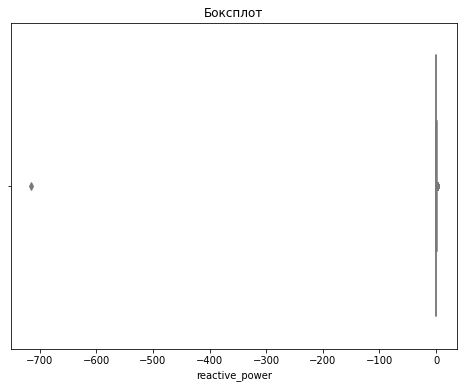

In [11]:
# Посмотрим на распредление через boxplot
boxplot(data_arc, 'reactive_power')

Действительно, это ошибка в данных. Удалить мы не можем, так как потеряем целую итерацию нагрева дугой. Посмотрим у какой партии было -715.

In [12]:
# Проверяем партию с отрицательным значением
data_arc[data_arc['reactive_power'] == -715.479924]

,arc_heating_start,arc_heating_end,active_power,reactive_power
key,,,,
2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [13]:
# Можно удалить аномалию 
data_arc = data_arc[data_arc['reactive_power'] != -715.479924]

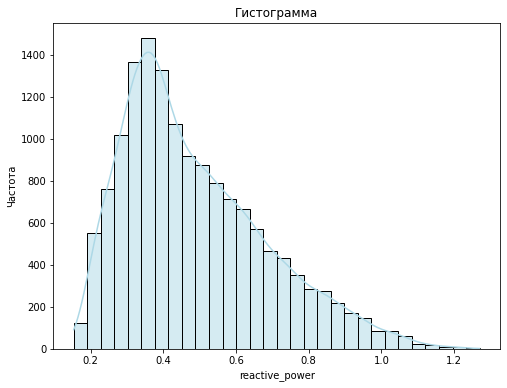

In [14]:
# Проверим распределение на гистограмме 
hist(data_arc, 'reactive_power', 30)

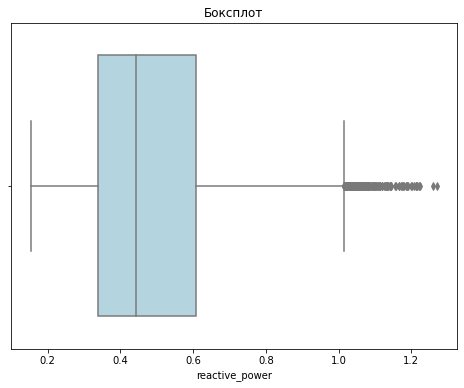

In [15]:
# Проверим распределение на боксплоте
boxplot(data_arc, 'reactive_power')

Распределение для reactive_power скошено вправо, с пиком в 0.35, а медианой в 0.45, что говорит о том, что большинстве случаев реактивная мощность держится на низком уровне. В выборке присутствуют выбросы.

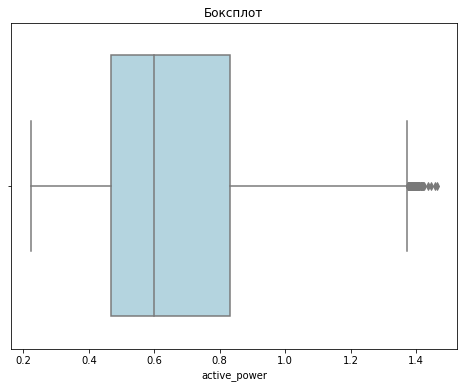

In [16]:
# Проверим распределение Активная мощность
boxplot(data_arc, 'active_power')

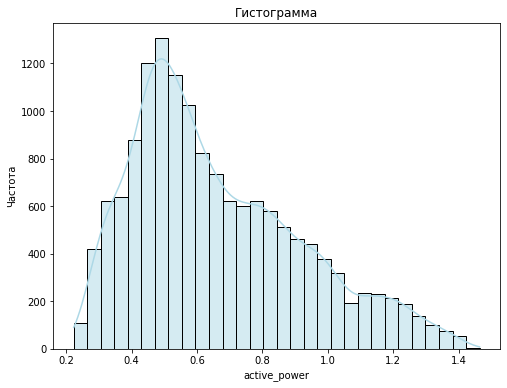

In [17]:
# Проверим распределение на гистограмме 
hist(data_arc, 'active_power', 30)

Распределение скошено вправо, значит большинство партий работают с низкой активной мощностью (в районе 0.5), но есть партии с более высокой мощностью, которые тянут хвост распределения вправо. Присутсвтуют выбросы.

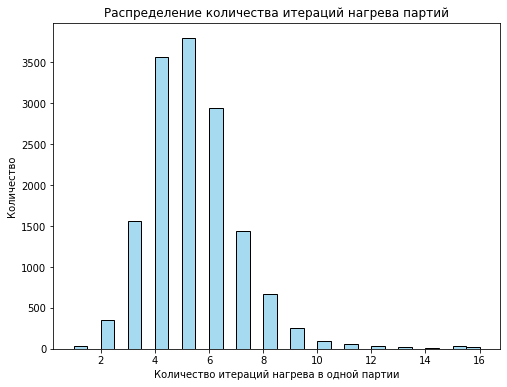

In [18]:
# Вычисляем количество итераций по каждой партии и смотрим на распределение
iteration_num_arc = data_arc.groupby('key')['active_power'].transform('count')

# Строим гистограмму
plt.figure(figsize=(8, 6))
sns.histplot(iteration_num_arc, bins=30, kde=False, color='skyblue')

plt.title('Распределение количества итераций нагрева партий')
plt.xlabel('Количество итераций нагрева в одной партии')
plt.ylabel('Количество')
plt.show()

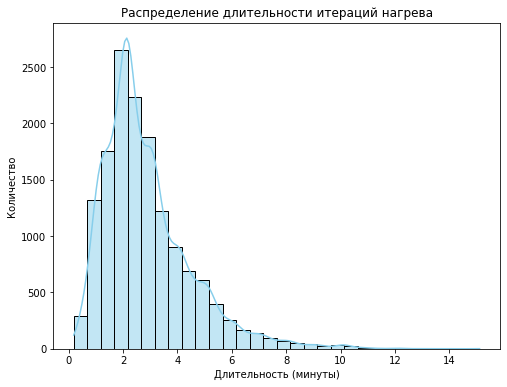

In [19]:
# Псмотрим теперь распределение времении на каждую итерацию
time_per_iter_arc = (data_arc['arc_heating_end'] - data_arc['arc_heating_start']).dt.total_seconds() / 60 

plt.figure(figsize=(8, 6))
sns.histplot(time_per_iter_arc, bins=30, kde=True, color='skyblue')

plt.title('Распределение длительности итераций нагрева')
plt.xlabel('Длительность (минуты)')
plt.ylabel('Количество')
plt.show()

В основном происходит 4 итерации на партию, где среднее время одной итерации 2 минуты. 

### Данные о подаче сыпучих материалов 

#### Объём подаваемого материала

In [20]:
data_bulk.info()
display(data_bulk.head(5))
display(data_bulk.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В файле `data_bulk` (данные о подаче сыпучих материалов (объём)):
- Столбцы `Bulk 1`...`Bulk 15` (объём подаваемого материала) содержит много пропусков. Заказчик сообщил, что сыпучие материалы не подавали в некоторых партиях, то есть нулевой объем. 
- Данные соответсвтуют типу.
- Названия параметров надо привести в snake_case

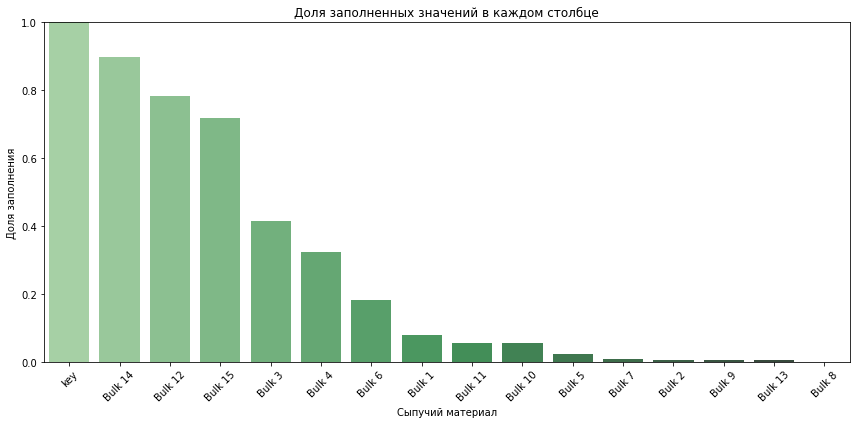

In [21]:
# Доля заполненных значений
filled_ratio = (data_bulk.notna().sum() / len(data_bulk)).sort_values(ascending=False)

# Строим график
plt.figure(figsize=(12, 6))
sns.barplot(x=filled_ratio.index, y=filled_ratio.values, palette='Greens_d')

plt.xticks(rotation=45)
plt.title('Доля заполненных значений в каждом столбце')
plt.ylabel('Доля заполнения')
plt.xlabel('Сыпучий материал')
plt.ylim(0, 1)  # ограничим от 0 до 1 для наглядности
plt.tight_layout()
plt.show()

Сыпучие материалы Bulk 6, 1, 11, 10, 5, 7, 2, 9, 13,8  используются при изготовлении менее 20% партий, можно их удалить, так как модель может не иметь достаточно информации для обучения, и они могут не улучшить результаты. 

In [22]:
# Проверка количества признаков до
display(data_bulk.shape)

# Удаляем столбцы с заполненностью менее 20%
data_bulk = data_bulk.drop(columns=filled_ratio[filled_ratio < 0.2].index)

# Проверка количества признаков
display(data_bulk.shape)
display(data_bulk.head(5))

(3129, 16)

(3129, 6)

,key,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
0,1,NaN,43.0,206.0,150.0,154.0
1,2,NaN,73.0,206.0,149.0,154.0
2,3,NaN,34.0,205.0,152.0,153.0
3,4,NaN,81.0,207.0,153.0,154.0
4,5,NaN,78.0,203.0,151.0,152.0


In [23]:
# Создаем словарь для перевода
translation_dict = {
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 12': 'bulk_12',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15'
}

# Переименовываем столбцы
data_bulk = data_bulk.rename(columns=translation_dict)

# Проверяем
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_3   1298 non-null   float64
 2   bulk_4   1014 non-null   float64
 3   bulk_12  2450 non-null   float64
 4   bulk_14  2806 non-null   float64
 5   bulk_15  2248 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 146.8 KB


In [24]:
# Заполняем пропуски нулями
data_bulk = data_bulk.fillna(0)

# Проверка пропусков
data_bulk.isna().sum()

key        0
bulk_3     0
bulk_4     0
bulk_12    0
bulk_14    0
bulk_15    0
dtype: int64

In [25]:
# Индексируем таблицу по key
data_bulk = data_bulk.set_index('key')
data_bulk.head(5)

,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
key,,,,,
1,0.0,43.0,206.0,150.0,154.0
2,0.0,73.0,206.0,149.0,154.0
3,0.0,34.0,205.0,152.0,153.0
4,0.0,81.0,207.0,153.0,154.0
5,0.0,78.0,203.0,151.0,152.0


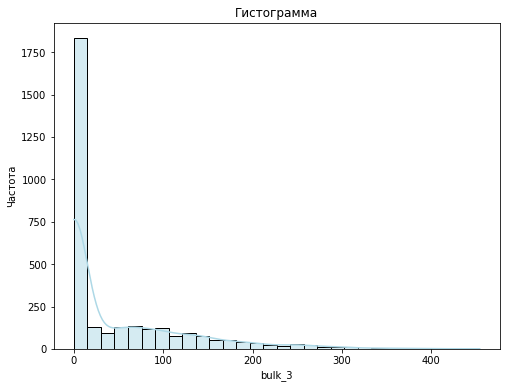

In [26]:
# Проверим распределение на гистограмме 
hist(data_bulk, 'bulk_3', 30)

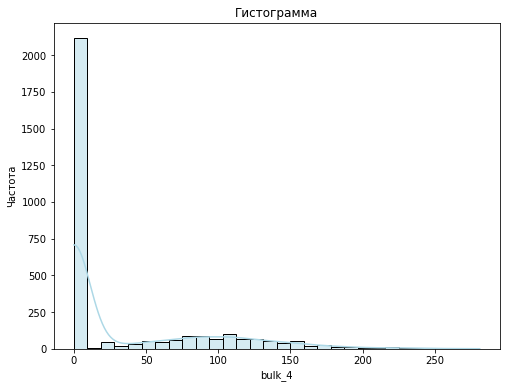

In [27]:
# Проверим распределение на гистограмме 
hist(data_bulk, 'bulk_4', 30)

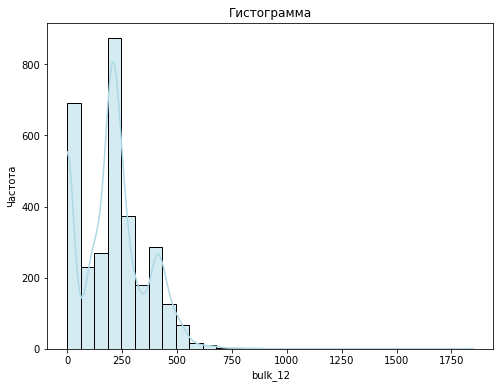

In [28]:
# Проверим распределение на гистограмме 
hist(data_bulk, 'bulk_12', 30)

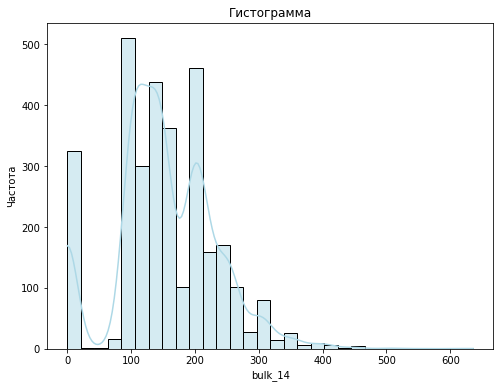

In [29]:
# Проверим распределение на гистограмме 
hist(data_bulk, 'bulk_14', 30)

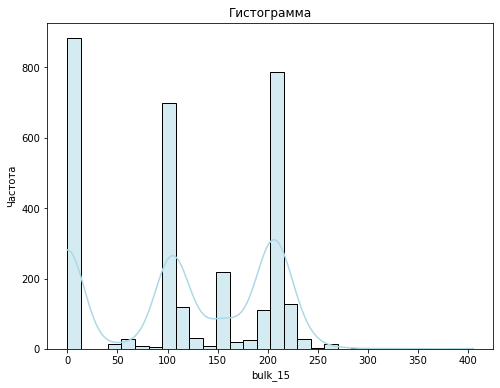

In [30]:
# Проверим распределение на гистограмме 
hist(data_bulk, 'bulk_15', 30)

Мы видим, что сыпучие материалы добавляли с разной частотой и обьемом:
- Bulk 3 в основном добавляли в небольших обьймах, где-то до 16.
- Bulk 4 тоже в небольших объемах до 10.
- Bulk 12 добавляли уже больше - до 500 в основном, с пиками в значениях 60 и 250.
- Bulk 14 добавляли в основном до 280 с пиками в значениях 20, 100, 150 и 200.
- Bulk 15 добавляли в значениях до 220, с пиками до 15, в 100, 150 и 220.

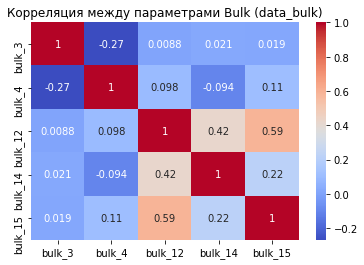

In [31]:
# Корреляции
sns.heatmap(data_bulk.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция между параметрами Bulk (data_bulk)')
plt.show()

Корреляция 0.59 между Bulk 12 и 15 говорит о умеренной положительной связи — то есть когда подача Bulk 12 увеличивается, подача Bulk 15 также склонна увеличиваться, и наоборот.

Корреляция 0.42 между Bulk 12 и 14 — это уже слабая/умеренная положительная связь, но всё же указывает на общую тенденцию подачи этих материалов вместе или в похожем режиме.

#### Время подачи материала

In [32]:
data_bulk_time.info()
display(data_bulk_time.head(5))
display(data_bulk_time.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


- Мы видим, что структуры таблиц data_bulk и data_bulk_time одинаковы.
- Необходимо привести тип данных к datetime64[ns]. 
- Индексировать таблицу по key.

In [33]:
# Фильтруем параметры как в data_bulk
data_bulk_time = data_bulk_time[['key', 'Bulk 3', 'Bulk 4', 'Bulk 12', 'Bulk 14',  'Bulk 15']]

columns = ['Bulk 3', 'Bulk 4', 'Bulk 12', 'Bulk 14',  'Bulk 15']

# Преобразуем данные в формат даты для каждого столбца
for column in columns:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column], errors='coerce')

# Индексируем таблицу по key
data_bulk_time = data_bulk_time.set_index('key') 

# Проверка
display(data_bulk_time.info())
display(data_bulk_time.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 3   1298 non-null   datetime64[ns]
 1   Bulk 4   1014 non-null   datetime64[ns]
 2   Bulk 12  2450 non-null   datetime64[ns]
 3   Bulk 14  2806 non-null   datetime64[ns]
 4   Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 146.7 KB


None

,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
key,,,,,
1,NaT,2019-05-03 11:28:48,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaT,2019-05-03 11:36:50,2019-05-03 11:53:30,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaT,2019-05-03 12:32:39,2019-05-03 12:27:13,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaT,2019-05-03 12:43:22,2019-05-03 12:58:00,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaT,2019-05-03 13:30:47,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47


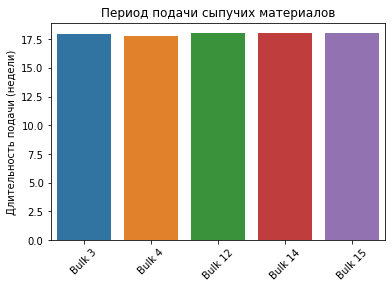

In [34]:
# Определем продолжительность добавления сыпучих материалов 
durations_weeks = {
    col: (data_bulk_time[col].max() - data_bulk_time[col].min()).total_seconds() / (86400 * 7)
    for col in data_bulk_time.columns
}

# Строим визуализацию
sns.barplot(x=list(durations_weeks.keys()), y=list(durations_weeks.values()))
plt.ylabel('Длительность подачи (недели)')
plt.title('Период подачи сыпучих материалов')
plt.xticks(rotation=45)
plt.show()

Все сыпучие материалы подавались в течении почти 17.6 недель.

### Данные о продувке сплава газом

In [40]:
data_gas.info()
display(data_gas.head(5))
display(data_gas.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


- Пропусков нет, данные соответствуют типу.
- Похоже, что в данных присутсвуют выбросы и распределение скошено вправо.
- Нужно переименовать второй параметр на английский и привести к snake_case и индексировать табллицу по key.

In [41]:
# Создаем словарь для перевода
translation_dict = {'Газ 1': 'gas_1'}

# Переименовываем столбцы
data_gas = data_gas.rename(columns=translation_dict)

# Индексируем таблицу по key
data_gas = data_gas.set_index('key')

# Проверка
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas_1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


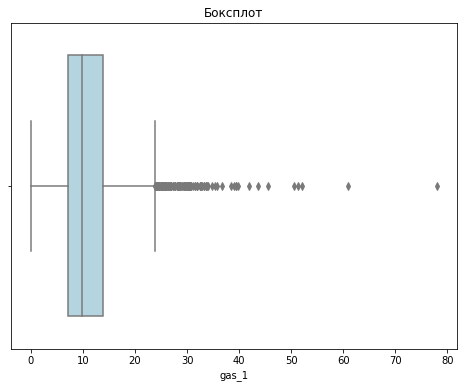

In [42]:
# Посмотрим на распредление по боксплоту
boxplot(data_gas, 'gas_1')

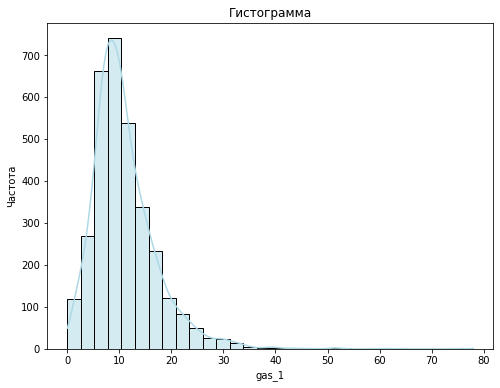

In [43]:
# Посмотрим на распредление по гистограмме
hist(data_gas, 'gas_1', 30)

Распределение продувки сплава газом имеет скошенность вправ, где медиана и средняя в районе 10, что говорит о том, что газ подавался в основном в небольших количествах, но присутствуют и большие значения (выбросы), которые тянут хвост распределения вправо. 

### Результаты измерения температуры

In [44]:
data_temp.info()
display(data_temp.head(5))
display(data_temp.tail(1))
display(data_temp.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Время замера,Температура
18091,3241,2019-09-06 17:30:05,NaN


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


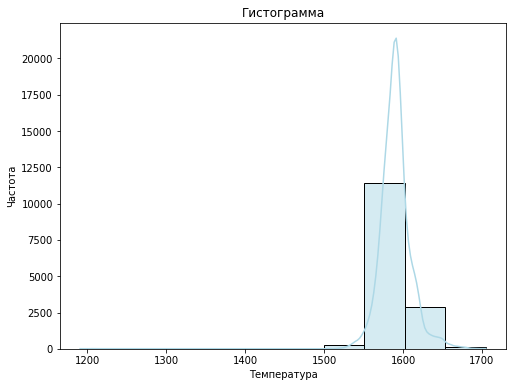

In [45]:
# Посмотрим на распредление по гистограмме
hist(data_temp, 'Температура', 10)

- За 3241 партии измерили температуру 18091 раз.
- Есть пропуски в параметре Температура.
- Тип данных в параметре Время замера надо поменять на datetime[ns].
- Необходимо переименовать стольбы и привести к типу snake_case, а также индексировать таблицу по key.
- Мы видим, что вернхние и нижние квартили больше 1500, но минимальное значение 1191. Заказчик сообщил, что нужно удалить строки со значением температуры <1500. 
- Средние значения близки к 1600.

In [46]:
# Создаем словарь для перевода
translation_dict = {
    'Время замера': 'datetime',
    'Температура': 'temperature'
}

# Переименовываем столбцы
data_temp = data_temp.rename(columns=translation_dict)

# Индексируем по key
data_temp = data_temp.set_index('key')

# Преобразуем тип данных в datetime
data_temp['datetime'] = pd.to_datetime(data_temp['datetime'])

# Удаляем строки с температурой < 1500
data_temp = data_temp[data_temp['temperature'] > 1500]

# Проверяем
data_temp.info()
display(data_temp.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     14660 non-null  datetime64[ns]
 1   temperature  14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 343.6 KB


,datetime,temperature
key,,
1,2019-05-03 11:02:04,1571.0
1,2019-05-03 11:07:18,1604.0
1,2019-05-03 11:11:34,1618.0
1,2019-05-03 11:18:04,1601.0
1,2019-05-03 11:25:59,1606.0


- Теперь мы проверим и удалим те партии, где был замер температуры только один раз, так как для нашей модели нужно знать начальный и последний замеры температуры, все остальное удаляем.
- Выделим начальную температуру first_temp и последнюю target.
- Добавим новый признак, это время между первым и последним замером.

In [47]:
# Убираем партии с одним замером
data_temp = data_temp.groupby('key').filter(lambda x: len(x) > 1)

# Фильтруем только первый и последний замер температуры для каждой партии
data_temp = data_temp.groupby('key').agg(
    first_temp=('temperature', 'first'), 
    target=('temperature', 'last'),
    first_datetime=('datetime', 'first'),
    last_datetime=('datetime', 'last')
)

# Показываем результат
display(data_temp.head(5))

,first_temp,target,first_datetime,last_datetime
key,,,,
1,1571.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:30:38
2,1581.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:55:09
3,1596.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:35:57
4,1601.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:59:47
5,1576.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:36:39


### Данные о проволочных материалах

#### Данные о проволочных материалах (объём):

In [48]:
data_wire.info()
display(data_wire.head(5))
display(data_wire.tail(1))
display(data_wire.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


- Количество записей 3080, а партии 3241, то есть не во все партии добавлялись лигирующие материалы.
- В таблице есть пропуски. Надо будет удалить пропуски более 80%.
- В первых нескольких признаках присутствуют выбросы.
- С типом данных все ок.
- Надо привести название параметров в snake_case и индексировать таблицу по key.

In [49]:
# Определяем порог для удаления столбцов с пропусками
threshold = 0.8

# Убираем столбцы, где пропуски более 80%
data_wire = data_wire.dropna(thresh=len(data_wire) * (1 - threshold), axis=1)

# Индексируем таблицу по key
data_wire = data_wire.set_index('key')

# Заполняем оставшиейся пропуски нулями
data_wire = data_wire.fillna(0)

# Проверяем результат
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3081 non-null   float64
 1   Wire 2  3081 non-null   float64
dtypes: float64(2)
memory usage: 72.2 KB


In [50]:
# Создаем словарь для перевода
translation_dict = {
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2'
}

# Переименовываем столбцы
data_wire = data_wire.rename(columns=translation_dict)

# Проверяем результат
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3081 non-null   float64
 1   wire_2  3081 non-null   float64
dtypes: float64(2)
memory usage: 72.2 KB


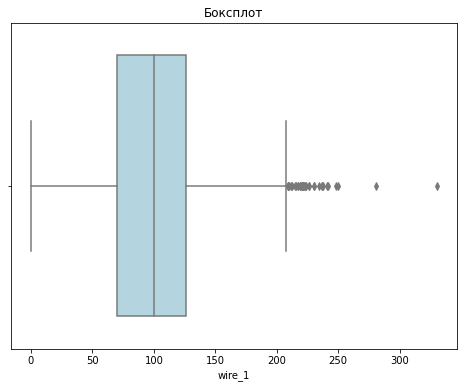

In [51]:
# Проверим распределение боксплоту
boxplot(data_wire, 'wire_1')

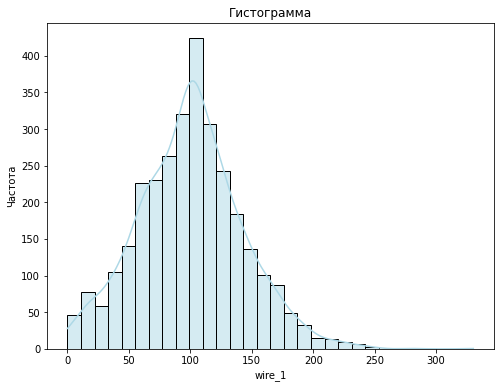

In [52]:
# Проверим распределение по гистограмме
hist(data_wire, 'wire_1', 30)

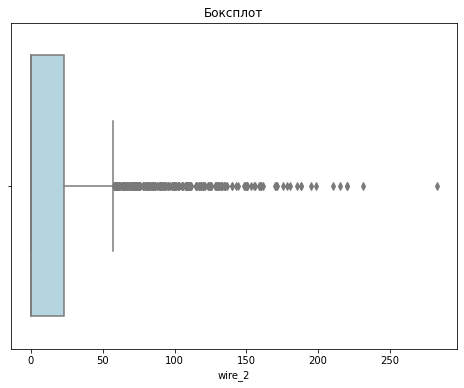

In [53]:
# Проверим распределение по боесплоту
boxplot(data_wire, 'wire_2')

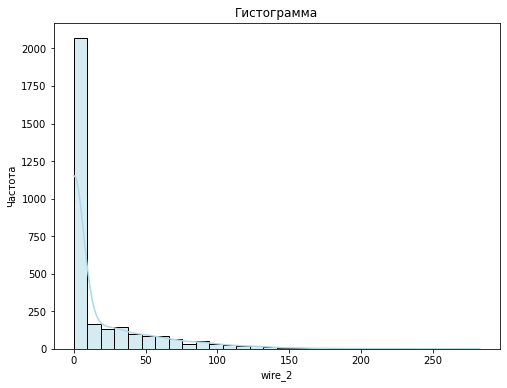

In [54]:
# Проверим распределение по гистограмме
hist(data_wire, 'wire_2', 30)

- У wire_1 распределение скошено право, со средним и медианой в значении 100. Есть выбросы.
- У wire_2 распределение тоже скошено вправо, со средним в значении 50, а медианой 40, с длинным хвостом выбросов.

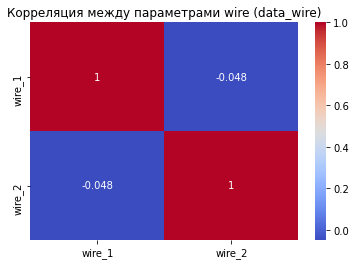

In [55]:
# Корреляции
sns.heatmap(data_wire.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция между параметрами wire (data_wire)')
plt.show()

Корелляции между wire_1 и wire_2 нет.

#### Данные о проволочных материалах (время):

In [56]:
data_wire_time.info()
display(data_wire_time.head(5))
display(data_wire_time.tail(1))
display(data_wire_time.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


- Мы видим, что структуры таблиц data_wire и data_wire_time одинаковы.
- Необходимо привести тип данных к datetime64[ns]. 
- Индексировать таблицу по key.

In [57]:
# Индексируем таблицу по key
data_wire_time = data_wire_time.set_index('key') 

# Оставляем только те данные, где заполненность больше 20%
data_wire_time = data_wire_time[['Wire 1', 'Wire 2']]

# Преобразуем данные в формате даты для каждого столбца
data_wire_time['Wire 1'] = pd.to_datetime(data_wire_time['Wire 1'], errors='coerce')
data_wire_time[ 'Wire 2'] = pd.to_datetime(data_wire_time['Wire 2'], errors='coerce')

# Проверка
display(data_wire_time.info())
display(data_wire_time.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 72.2 KB


None

,Wire 1,Wire 2
key,,
1,2019-05-03 11:06:19,NaT
2,2019-05-03 11:36:50,NaT
3,2019-05-03 12:11:46,NaT
4,2019-05-03 12:43:22,NaT
5,2019-05-03 13:20:44,2019-05-03 13:15:34


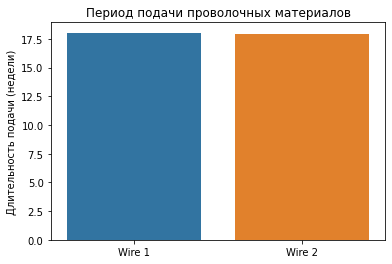

In [60]:
# Считаем разницу между max и min по каждому нужному столбцу
durations_weeks = {
    col: (data_wire_time[col].max() - data_wire_time[col].min()).total_seconds() / (86400 * 7)
    for col in ['Wire 1', 'Wire 2']
}

# Построим график сразу
sns.barplot(x=list(durations_weeks.keys()), y=list(durations_weeks.values()))
plt.ylabel('Длительность подачи (недели)')
plt.title('Период подачи проволочных материалов')
plt.show()

Все проволочные материалы подавались в течении почти 17.6 недель.

### Общий вывод по исследовательскому анализу данных (EDA)

В ходе исследовательского анализа были изучены все предоставленные наборы данных, описывающие различные этапы процесса обработки стали (нагрев дугой, добавление сыпучих и проволочных материалов, продувка газом, замеры температуры).

**Ключевые результаты и выполненные действия:**

*Очистка и Предобработка: Данные потребовали значительной очистки:

- Исправлены типы данных (особенно даты/время).
- Обработаны пропуски: для объемов добавок (bulk/wire) пропуски интерпретированы как нулевое использование; удалены записи с температурой < 1500°C и партии с единственным замером температуры.
- Устранены аномалии (удалена запись с отрицательной реактивной мощностью).
- Стандартизированы названия столбцов (приведены к snake_case).
- Отбор Признаков: Проведен отбор признаков для повышения качества будущей модели:

- Удалены столбцы проволочных материалов (Wire 3 - Wire 9, Wire 6, Wire 5 и т.д.) с долей пропусков > 80%.
- Удалены столбцы сыпучих материалов (Bulk кроме 3, 4, 12, 14, 15), которые использовались менее чем в 20% партий.

**Анализ Свойств Данных:**

- Выявлено, что распределения многих ключевых числовых признаков (мощность, газ, объемы добавок) скошены вправо, часто присутствуют выбросы.
- Обнаружена умеренная корреляция между использованием некоторых сыпучих материалов (Bulk 12, 14, 15).

**Подготовка к Моделированию:**

- Определены важнейшие признаки для модели: начальная температура (first_temp) и конечная температура (target).

## Геренация новых параметров

- Сгенерируем новые признаки: 
   - Время между первым и последним замером температуры `data_temp['time_between']`.
   - Количество итераций по каждой партии `data_arc['iteration_num_arc']`.
   - Время на итерацию `data_arc['time_per_iter_arc']`.
   - Сумма времени нагрева на партию `data_arc['sum_time_per_key']`.

In [61]:
# Рассчитываем время между первым и последним замером (в минутах)
data_temp['time_between_temp'] = (data_temp['last_datetime'] - data_temp['first_datetime']).dt.total_seconds() / 60

# Убираем лишние столбцы времени в data_temp
data_temp = data_temp.drop(columns=['first_datetime', 'last_datetime'])

# Создаем новые параметры: количество итерации за дугу и время за итерацию
data_arc['iteration_num_arc'] =  iteration_num_arc
data_arc['time_per_iter_arc'] = time_per_iter_arc

# Вычисляем сумму времени на партию (по ключу 'key')
data_arc['sum_time_per_key'] = data_arc.groupby('key')['time_per_iter_arc'].transform('sum')

# Убираем лишние столбцы времени
data_arc = data_arc.drop(columns=['arc_heating_start', 'arc_heating_end'])

# Проверяем
display(data_temp.info())
display(data_arc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temp         2475 non-null   float64
 1   target             2475 non-null   float64
 2   time_between_temp  2475 non-null   float64
dtypes: float64(3)
memory usage: 77.3 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       14875 non-null  float64
 1   reactive_power     14875 non-null  float64
 2   iteration_num_arc  14875 non-null  int64  
 3   time_per_iter_arc  14875 non-null  float64
 4   sum_time_per_key   14875 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 697.3 KB


None

<a id='объединение'></a>
## Объединение данных

Перед оъединением выполним агрегацию датасета `data_arc`.

In [62]:
# Агрегируем данные по ключу (партии)
data_arc = data_arc.groupby('key').agg(
    {
        'active_power': 'median',  # Среднее значение для активной мощности
        'reactive_power': 'median',  # Среднее значение для реактивной мощности
        'time_per_iter_arc': 'mean',  # Среднее время на итерацию
        'iteration_num_arc': 'first',  # Количество итераций в партии
        'sum_time_per_key': 'first'  
    }
)

# Проверка
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       3214 non-null   float64
 1   reactive_power     3214 non-null   float64
 2   time_per_iter_arc  3214 non-null   float64
 3   iteration_num_arc  3214 non-null   int64  
 4   sum_time_per_key   3214 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


In [63]:
# Список всех датасетов
datasets = [data_arc, data_bulk, data_gas, data_temp, data_wire]

# Объединяем все датасеты поочередно с использованием reduce
df = reduce(lambda left, right: left.merge(right, left_index=True, right_index=True, how='inner'), datasets)

# Просмотр первых нескольких строк объединённого датасета
display(df.head(5))
display(df.tail(1))

,active_power,reactive_power,time_per_iter_arc,iteration_num_arc,sum_time_per_key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas_1,first_temp,target,time_between_temp,wire_1,wire_2
key,,,,,,,,,,,,,,,,
1,0.580313,0.430460,3.660000,5,18.300000,0.0,43.0,206.0,150.0,154.0,29.749986,1571.0,1613.0,28.566667,60.059998,0.00000
2,0.545710,0.352656,3.379167,4,13.516667,0.0,73.0,206.0,149.0,154.0,12.555561,1581.0,1602.0,21.083333,96.052315,0.00000
3,0.774632,0.505690,2.183333,5,10.916667,0.0,34.0,205.0,152.0,153.0,28.554793,1596.0,1599.0,29.216667,91.160157,0.00000
4,0.753970,0.580275,3.087500,4,12.350000,0.0,81.0,207.0,153.0,154.0,18.841219,1601.0,1625.0,20.333333,89.063515,0.00000
5,0.517715,0.374041,3.620833,4,14.483333,0.0,78.0,203.0,151.0,152.0,5.413692,1576.0,1602.0,25.600000,89.238236,9.11456


,active_power,reactive_power,time_per_iter_arc,iteration_num_arc,sum_time_per_key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas_1,first_temp,target,time_between_temp,wire_1,wire_2
key,,,,,,,,,,,,,,,,
2499,0.370014,0.266499,3.679167,4,14.716667,47.0,0.0,233.0,126.0,227.0,11.336151,1569.0,1603.0,25.616667,110.160958,50.00528


Отлично, у нас нет ключей с номерами более 2500 по требованию задания.

<a id='анализ'></a>
## Исследовательский анализ и предобработка объединенного датафрейма

In [64]:
df.info()
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       2329 non-null   float64
 1   reactive_power     2329 non-null   float64
 2   time_per_iter_arc  2329 non-null   float64
 3   iteration_num_arc  2329 non-null   int64  
 4   sum_time_per_key   2329 non-null   float64
 5   bulk_3             2329 non-null   float64
 6   bulk_4             2329 non-null   float64
 7   bulk_12            2329 non-null   float64
 8   bulk_14            2329 non-null   float64
 9   bulk_15            2329 non-null   float64
 10  gas_1              2329 non-null   float64
 11  first_temp         2329 non-null   float64
 12  target             2329 non-null   float64
 13  time_between_temp  2329 non-null   float64
 14  wire_1             2329 non-null   float64
 15  wire_2             2329 non-null   float64
dtypes: float64(15), int64(1)

,active_power,reactive_power,time_per_iter_arc,iteration_num_arc,sum_time_per_key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas_1,first_temp,target,time_between_temp,wire_1,wire_2
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,0.635343,0.466244,2.867174,4.695148,13.460011,47.348218,37.303564,208.415629,153.853585,119.952769,11.375600,1587.386003,1593.365393,38.696837,102.443601,17.609859
std,0.151622,0.113304,0.729031,1.606948,5.681622,75.310430,58.643238,157.062272,81.404354,84.640443,6.392041,23.619841,11.200915,23.086525,43.539993,33.624771
min,0.235282,0.167425,0.950000,1.000000,0.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,4.500000,0.000000,0.000000
25%,0.521240,0.382405,2.350000,4.000000,9.683333,0.000000,0.000000,105.000000,105.000000,0.000000,7.282948,1571.000000,1587.000000,26.316667,73.207679,0.000000
50%,0.613501,0.451968,2.825000,5.000000,12.966667,0.000000,0.000000,206.000000,149.000000,107.000000,10.100950,1587.000000,1593.000000,34.083333,101.119201,0.000000
75%,0.725005,0.534515,3.312500,6.000000,16.550000,80.000000,77.000000,282.000000,204.000000,204.000000,14.216688,1603.000000,1598.000000,46.516667,128.091599,23.102560
max,1.268378,0.995877,6.300000,16.000000,69.816667,454.000000,281.000000,1849.000000,636.000000,405.000000,77.995040,1660.000000,1653.000000,394.566667,330.314424,282.780152


- Отлично, у нас получилось не больше 2332 записей.
- 15 параметров.
- Пропусков нет.
- Выбросы у нас есть в некоторых параметрах.

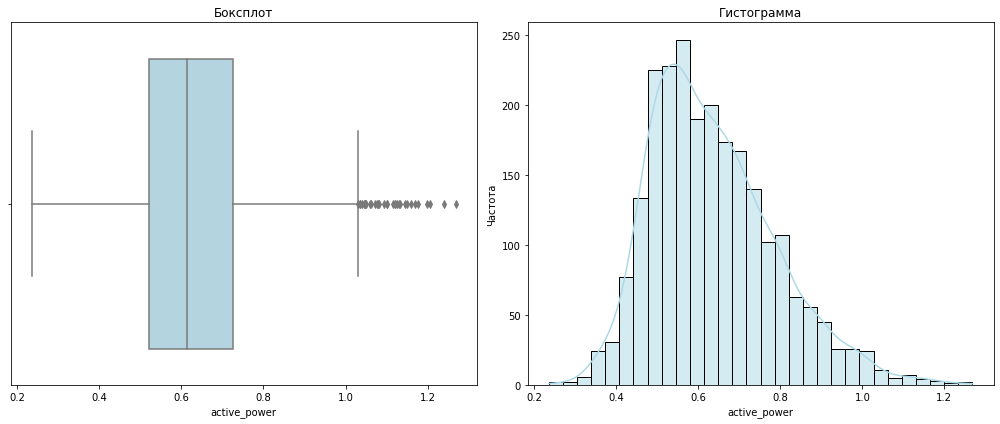

In [65]:
plot_distribution(df, 'active_power', 30)

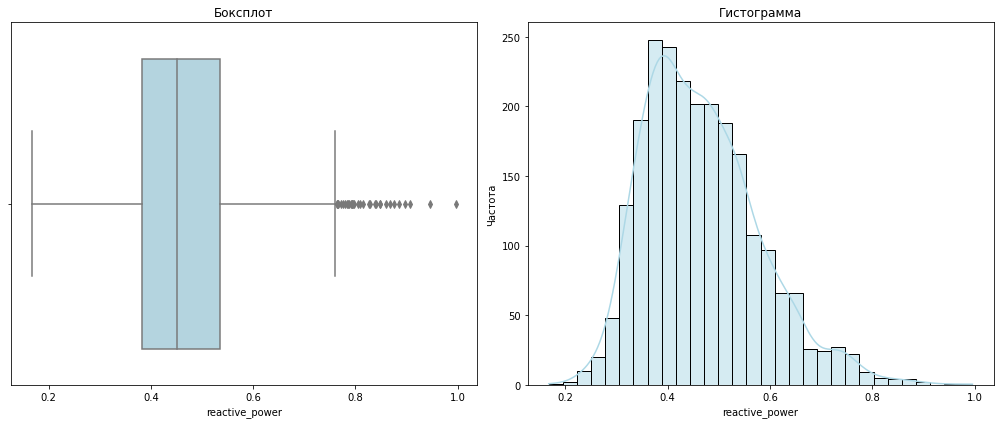

In [66]:
plot_distribution(df, 'reactive_power', 30)

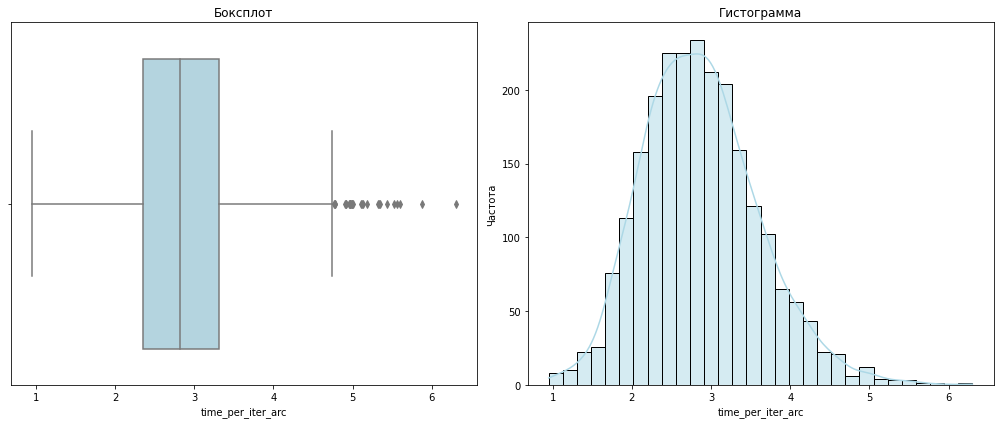

In [67]:
plot_distribution(df, 'time_per_iter_arc', 30)

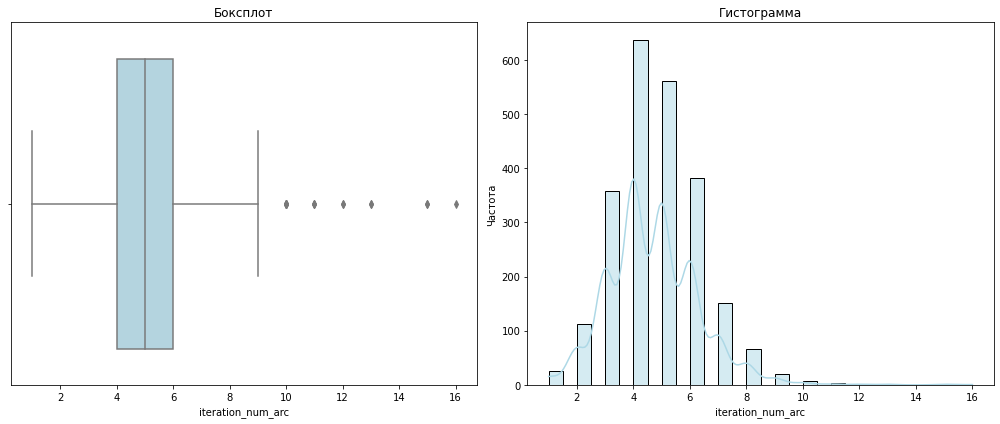

In [68]:
plot_distribution(df, 'iteration_num_arc', 30)

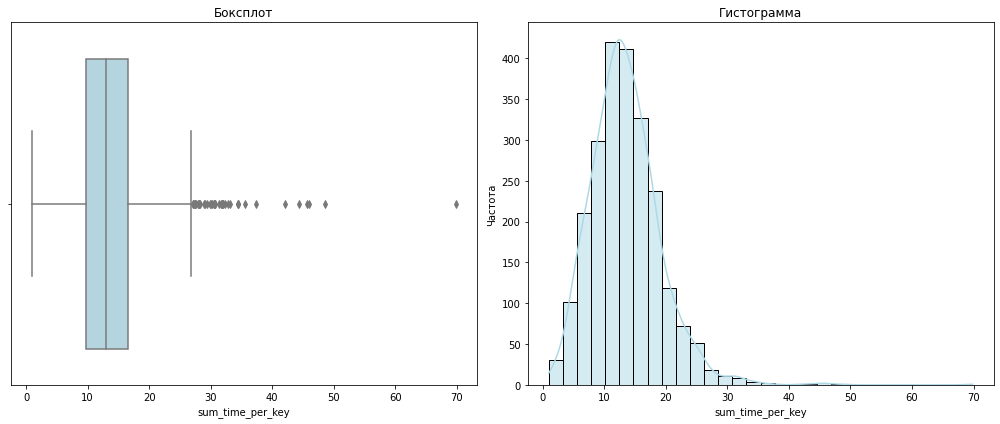

In [69]:
plot_distribution(df, 'sum_time_per_key', 30)

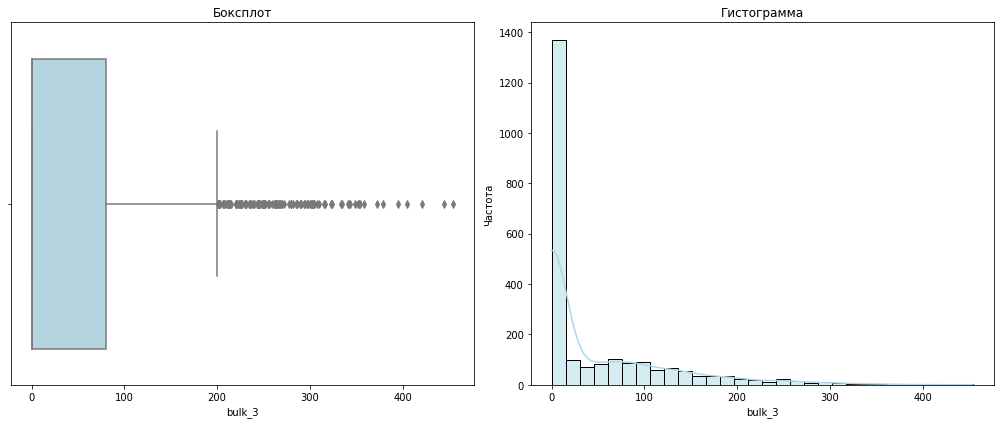

In [70]:
plot_distribution(df, 'bulk_3', 30)

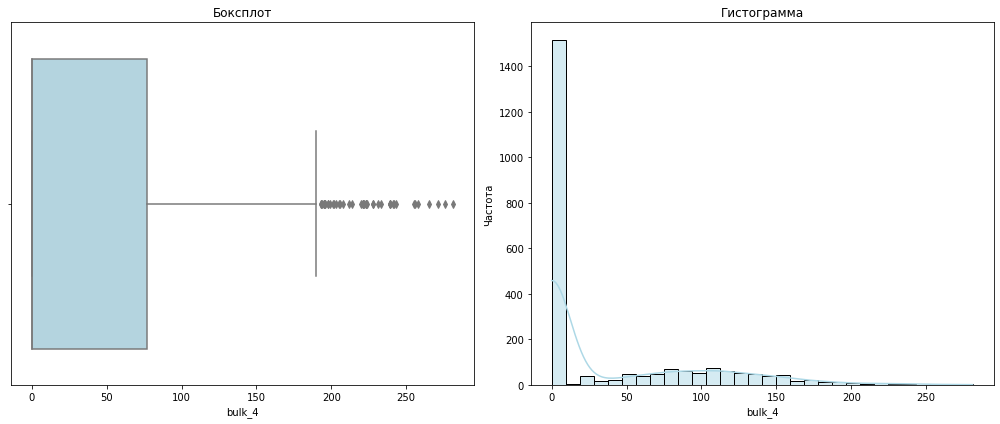

In [71]:
plot_distribution(df, 'bulk_4', 30)

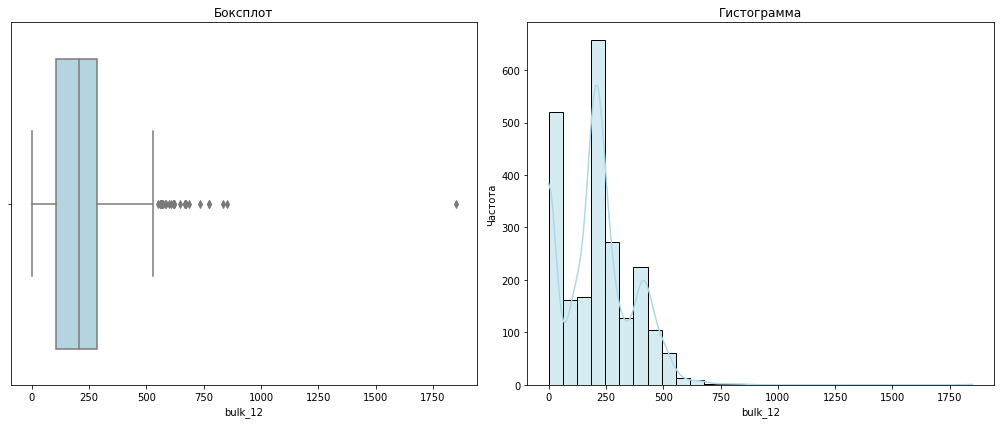

In [72]:
plot_distribution(df, 'bulk_12', 30)

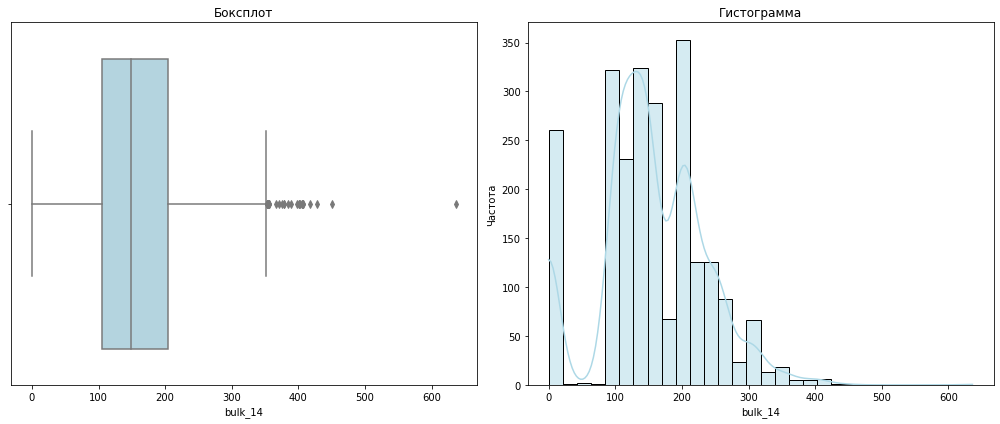

In [73]:
plot_distribution(df, 'bulk_14', 30)

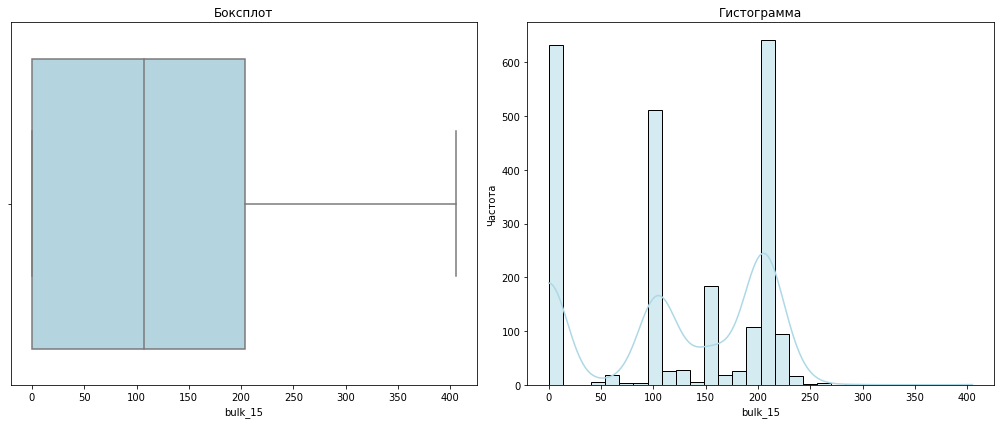

In [74]:
plot_distribution(df, 'bulk_15', 30)

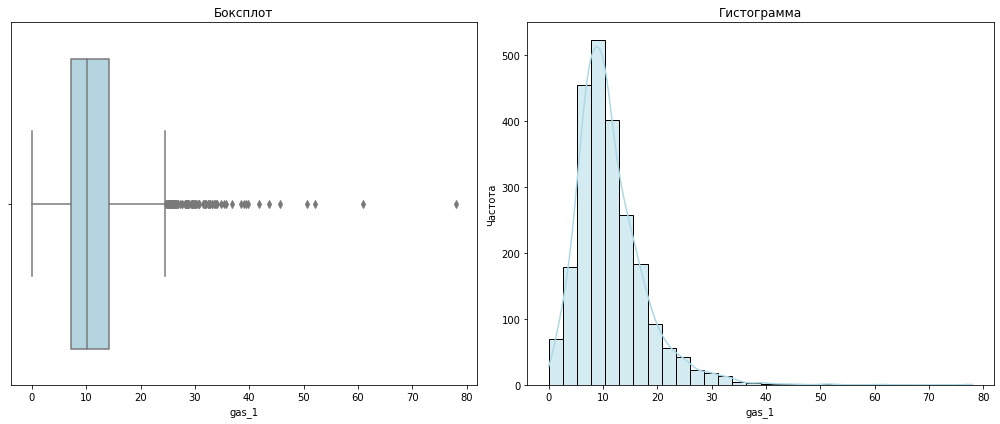

In [75]:
plot_distribution(df, 'gas_1', 30)

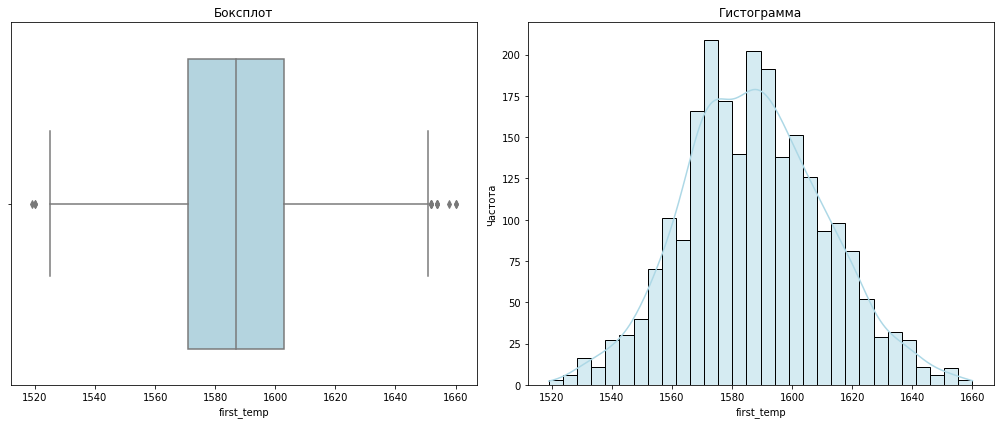

In [76]:
plot_distribution(df, 'first_temp', 30)

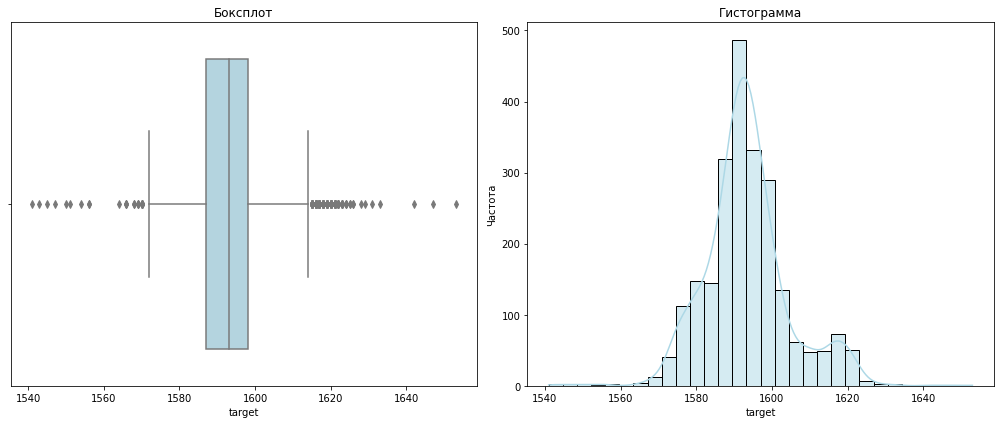

In [77]:
plot_distribution(df, 'target', 30)

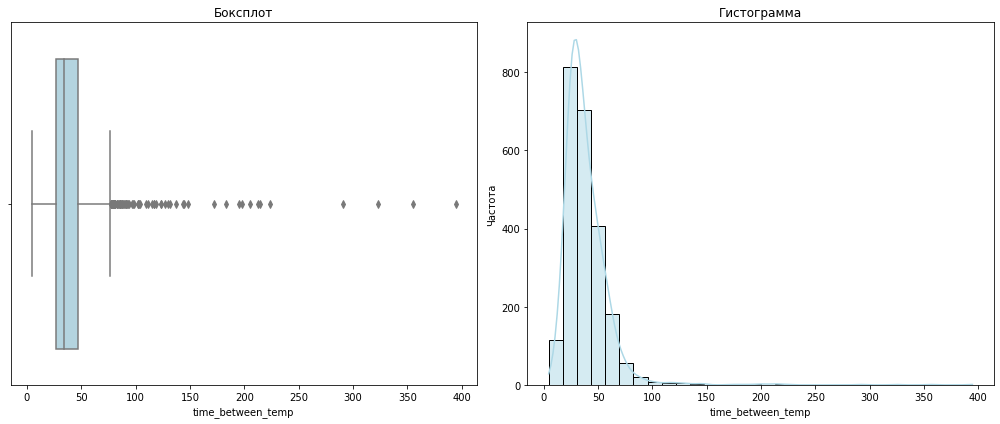

In [78]:
plot_distribution(df, 'time_between_temp', 30)

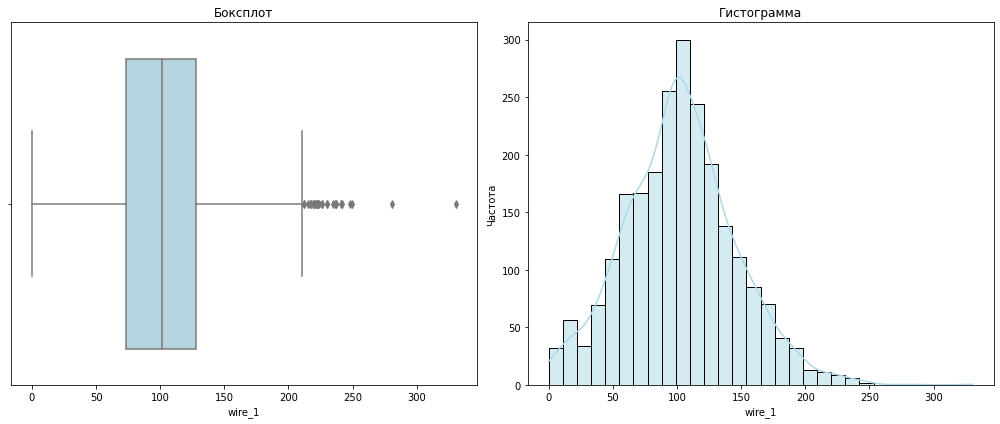

In [79]:
plot_distribution(df, 'wire_1', 30)

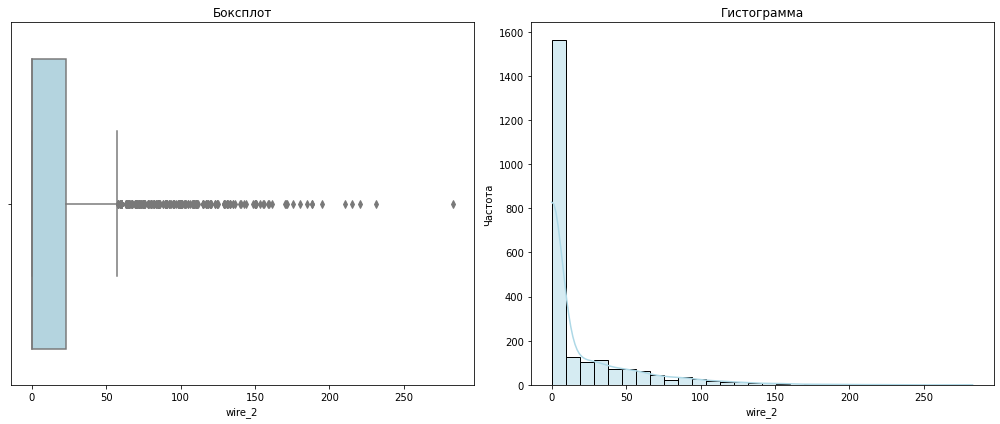

In [80]:
plot_distribution(df, 'wire_2', 30)

** Dывод по EDA объединенного датафрейма:**

- *Преобладание скошенности вправо*: Большинство входных признаков (`active_power, reactive_power, gas_1, time_between_temp, wire_1, wire_2, bulk_3, bulk_4, iteration_num_arc, time_per_iter_arc`) имеют распределения, скошенные вправо. Это говорит о том, что для большинства партий значения этих параметров находятся в нижнем или среднем диапазоне, но существуют операции с заметно более высокими значениями (длинные "хвосты" вправо).
- *Наличие выбросов*: Почти все рассмотренные числовые признаки содержат выбросы, в основном верхние. Это указывает на нетипичные значения в данных.
- *Мультимодальность*: Некоторые признаки (`bulk_12, bulk_15, first_temp`) имеют мультимодальные распределения (несколько пиков), что может указывать на наличие нескольких типичных режимов или дозировок в процессе.
- *Целевая переменная*: Распределение конечной температуры (`target`) близко к нормальному, с центром около 1593°C, что является хорошей предпосылкой для регрессионных моделей. Выбросы также присутствуют.
- *Признаки с высокой долей малых/нулевых значений*: Признаки `bulk_3, bulk_4, wire_2` сильно смещены к малым значениям (возможно, к нулю, судя по отсутствию информации о медиане/Q1 в заметках), что отражает их специфику использования.

Наличие скошенности и выбросов во многих признаках указывает на необходимость масштабирования данных (StandardScaler) перед обучением линейной модели, чувствительной к масштабу. Модели на основе деревьев могут быть менее чувствительны. Распределение целевой переменной не требует специальных преобразований.

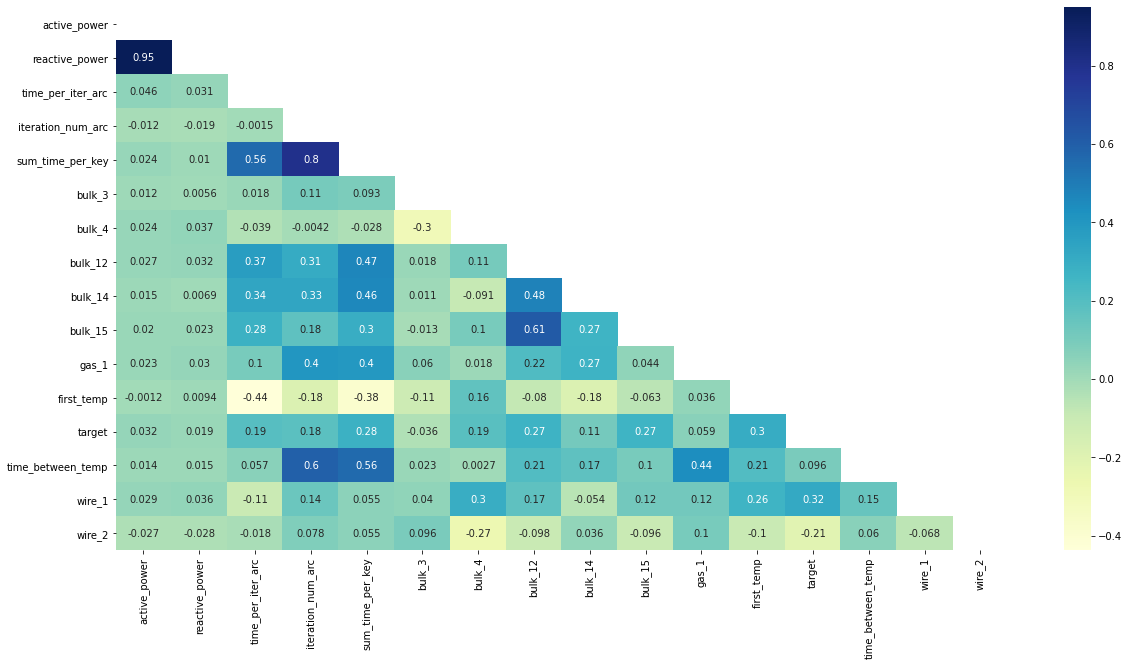

In [81]:
# Рассчитываем корреляцию
corr = df.corr()

# Создаём маску для верхнего треугольника
mask = np.triu(np.ones_like(corr, dtype=bool))

# Строим тепловую карту
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='YlGnBu', mask=mask, cbar=True)
plt.show()

- Очень высокая корреляция между `active_power` и `reactive_power (0.95)`. Удалим reactive_power так это менее важный параметр, чем active_power, который непосредственно связан с потреблением энергии.
- Высокая корреляция между `sum_time_per_key` и `iteration_num_arc (0.8)`
- Средняя кореляция между `time_between_temp` и `iteration_bum_arc (0.6)`, `bulk_12` и `bulk_15 (0.61)`, `sum_time_per_key` и `time_per_iter_arc (0.56)`.

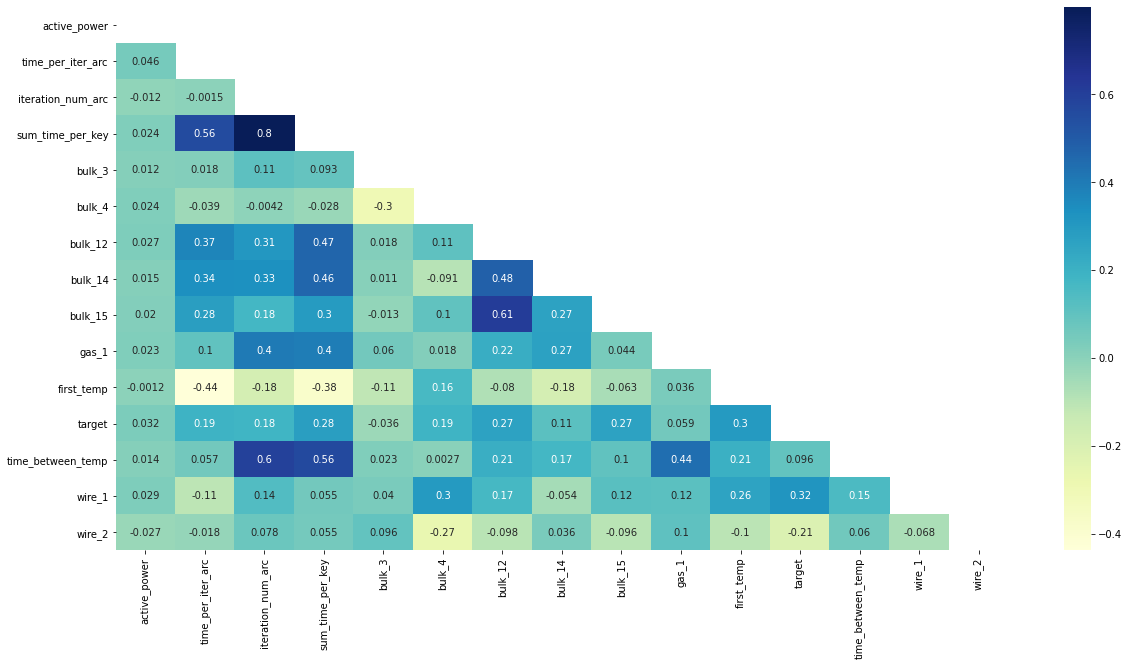

In [82]:
# Удаляем признак
df = df.drop('reactive_power', axis=1)

# Проверяем
corr = df.corr()

# Создаём маску для верхнего треугольника
mask = np.triu(np.ones_like(corr, dtype=bool))

# Строим тепловую карту
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='YlGnBu', mask=mask, cbar=True)
plt.show()

Отлично, признак reactive_power с высокой корреляцией (>=0.9) удален.

<a id='подготовка'></a>
## Подготовка данных для моделирования

- Разделим данные на тренировочную, валидационную и тестовую. 
- По требования заказчика в обучающей выборке должно быть > 1700 записей.

In [83]:
# Проверим, заполнились ли ли пропуски нулями в bulk и wire
display((df[['bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2']] == 0).sum())

bulk_3     1369
bulk_4     1517
bulk_12     517
bulk_14     261
bulk_15     630
wire_1       23
wire_2     1518
dtype: int64

In [84]:
# Разбиваем данные на обучающую и тестовую выборки
X = df.drop('target', axis=1)  # Признаки
y = df['target']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

display(X_train.shape)

(1746, 14)

В обучающей выборке содержится 1746 строк, что соответствует требованиям (>1700). Пропуски в признаках bulk и wire были заполнены нулями, выбросы не удалялись — данные были только визуализированы с помощью боксплотов на этапе EDA.

<a id='обучение'></a>
## Обучение и настройка моделей

### Linear Regression

In [85]:
# Пайплайн для линейной регрессии (масштабирование данных обязательно)
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),   # Масштабирование данных
    ('lr', LinearRegression())      # Линейная регрессия
])

# Кросс-валидация для линейной регрессии с использованием cross_val_score
cv_scores_lr = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
mean_lr_score = -cv_scores_lr.mean()  # Средний MAE для линейной регрессии
print(f"Средняя MAE для Linear Regression (cross-validation): {mean_lr_score:.4f}")

Средняя MAE для Linear Regression (cross-validation): 6.2072


### RandomForest

In [86]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

# Параметры для GridSearchCV для случайного леса
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Кросс-валидация для случайного леса с GridSearchCV
grid_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

# Лучший результат для случайного леса
best_rf_score = -grid_rf.best_score_
print(f"Лучшая оценка у Random Forest(MAE): {best_rf_score:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшая оценка у Random Forest(MAE): 6.3041


### LightGBM

In [87]:
model_gbm = LGBMRegressor(random_state=RANDOM_STATE)

# Параметры для GridSearchCV для LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Кросс-валидация для LightGBM с GridSearchCV
grid_lgb = GridSearchCV(model_gbm, param_grid_lgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_lgb.fit(X_train, y_train)

# Лучший результат для LightGBM
best_lgb_score = -grid_lgb.best_score_
print(f"Лучшая оценка LightGBM CV (MAE): {best_lgb_score:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшая оценка LightGBM CV (MAE): 6.0964


<a id='выбор'></a>
## Оценка и выбор лучшей модели

По результатам оценки на кросс валидации лучшую оценку показала модель LightGBM c результатом MAE 6.0964.

In [88]:
# Лучшие параметры для модели LGBM
лучшие_параметры_lgb = grid_lgb.best_params_
print(f"Лучшие параметры для LGBM: {лучшие_параметры_lgb}")

# Применяем лучшую модель на тестовой выборке
y_pred = grid_lgb.best_estimator_.predict(X_test)

# Оценка MAE на тестовой выборке
mae_test = mean_absolute_error(y_test, y_pred)
print(f"MAE на тестовой выборке: {mae_test:.4f}")

# Рассчитываем метрику R2
r2 = r2_score(y_test, y_pred)
print(f"Оценка R2 на тестовой выборке: {r2:.4f}")

Лучшие параметры для LGBM: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}
MAE на тестовой выборке: 5.9552
Оценка R2 на тестовой выборке: 0.3905


На тестовой выборке модель LightGBM показала коэффициент детерминации R² = 0.39. Это означает, что почти 40% результата можно предсказать по данным, остальное — это шум, неучтённые параметры или нестабильность процесса.

In [89]:
# Оценка DummyRegressor на тестовой выборке
dummy_regressor = DummyRegressor(strategy="mean")  
dummy_regressor.fit(X_train, y_train)

y_pred_dummy = dummy_regressor.predict(X_test)

# MAE 
mae_test_dummy = mean_absolute_error(y_test, y_pred_dummy)

print(f"MAE на тестовой выборке для DummyRegressor: {mae_test_dummy:.4f}")

MAE на тестовой выборке для DummyRegressor: 7.4321


Лушая модель LightGBM (MAE 5.95) улучшила результат по сравнению с базовой моделью (DummyRegressor: MAE 7.43), что хорошо.

<a id='оценка'></a>
## Оценка важности признаков

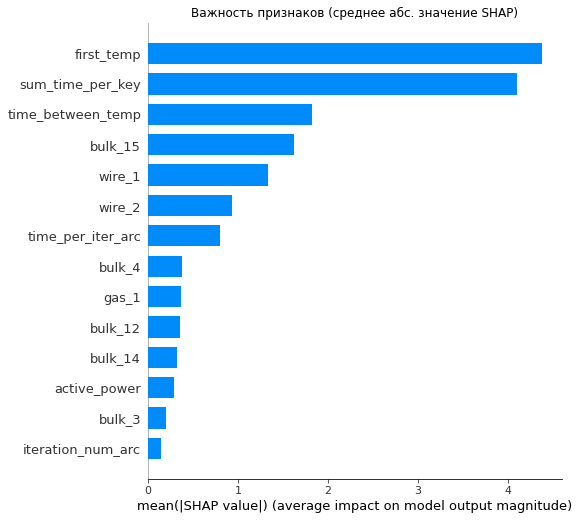

In [90]:
# Создаем explainer и рассчитываем значения SHAP для тестовой выборки
explainer = shap.TreeExplainer(grid_lgb.best_estimator_)
shap_values = explainer.shap_values(X_test)

# График важности признаков (Bar Plot)
plt.figure(figsize=(10, 6)) 
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Важность признаков (среднее абс. значение SHAP)')
plt.show()

Лидерами среди важных признаков оказались:
- Первая температура `first_temp`
- Суммарное время нагрева дугой для одной партии `sum_time_per_key`

Среднее влияние у:
- Время между первым и последний замером `time_between_temp`
- Сыпучего материала `bulk_15`
- Проволочного матириала `wire_1`

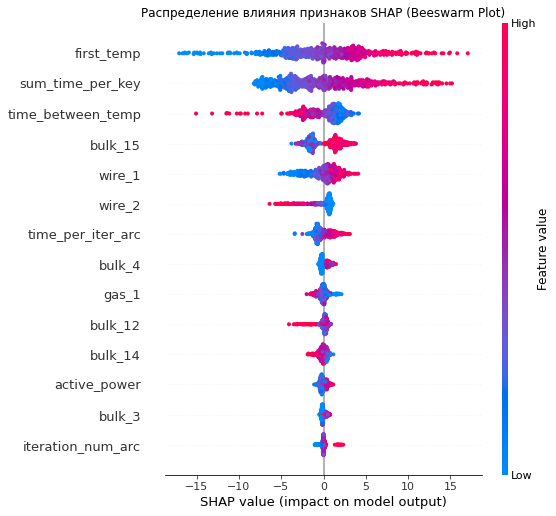

In [91]:
# График распределения влияния признаков (Beeswarm Plot)
plt.figure(figsize=(10, 8)) # Можно настроить размер
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title('Распределение влияния признаков SHAP (Beeswarm Plot)')
plt.show()

**Анализ влияния признаков с помощью SHAP показал:**

- `first_temp` является наиболее значимым фактором: низкая начальная температура стабильно снижает прогноз конечной, а высокая — повышает. При этом сила влияния значительно варьируется от партии к партии (широкое облако SHAP).
- `sum_time_per_key` (суммарное время нагрева) также оказывает существенное влияние: более длительный нагрев повышает прогнозируемую температуру, короткий — понижает. Вариативность влияния несколько ниже, чем у `first_temp`.
- `time_between_temp` (время между замерами) имеет заметное влияние, причем увеличение этого времени склонно уменьшать предсказание конечной температуры. Вариативность влияния также присутствует.
- `bulk_15` оказывает очень стабильное, но, по-видимому, слабое влияние на конечную температуру (узкое облако SHAP).
- `wire_1` также влияет достаточно стабильно (среднее облако), и его добавление (в малых количествах) имеет тенденцию уменьшать прогнозируемую температуру.
- `wire_1` его добавление (в высоких количествах) имеет тенденцию уменьшать прогнозируемую температуру.

<a id='вывод'></a>
## Формулирование выводов и рекомендаций

В рамках проекта для металлургического комбината «Стальная птица» была построена модель машинного обучения для прогнозирования конечной температуры стали после обработки в ковше. Проведены очистка, агрегация и объединение семи разрозненных источников данных, выявлены и устранены аномалии и пропуски. В результате подготовки были сформированы ключевые признаки, отражающие параметры нагрева, добавления материалов и замеров температуры.

- Наилучший результат достигнут с моделью `LightGBM`, показавшей `MAE = 5.95` и `R² = 0.39` на тестовой выборке, что соответствует целевым метрикам и значительно превосходит базовую модель `(DummyRegressor, MAE = 7.43)`. 
- Лучшие параметры для `LightGBM: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}`. Был использован `RANDOM_STATE = 70425`.
- Метрика `R² = 0.39` означает, что модель объясняет почти 40% изменений конечной температуры на основе имеющихся данных. Остальные колебания связаны с шумами, нестабильностью процесса или неучтёнными параметрами, которые не представлены в текущих датасетах.

Анализ важности признаков с помощью метода SHAP позволил не только определить наиболее влиятельные факторы, но и понять характер их влияния на предсказание конечной температуры:

**Лидеры по важности:**
- `first_temp` (начальная температура): Оказывает наибольшее влияние. Низкие значения стабильно снижают прогноз, высокие — повышают. При этом сила влияния может значительно варьироваться от партии к партии.
- `sum_time_per_key` (суммарное время нагрева): Второй по важности признак. Увеличение времени нагрева повышает прогнозируемую температуру. Влияние менее вариативно, чем у first_temp.

**Признаки со средним влиянием:**
- `time_between_temp` (время между замерами): Увеличение этого времени склонно уменьшать предсказание конечной температуры; влияние вариативно.
- `bulk_15` и `wire_1` (сыпучий материал и проволочный материалы): Влияние стабильное, но относительно слабое.
- `wire_2` (проволочный материал): Влияние стабильное; его добавление в среднем уменьшает прогнозируемую температуру.

**Рекомендации для бизнеса**

- *Внедрение модели*: Рекомендуется внедрить обученную модель LightGBM в производственный цикл как инструмент поддержки принятия решений для прогнозирования температуры и последующей оптимизации энергозатрат.
- *Фокус на ключевых факторах*: Уделять особое внимание контролю начальной температуры (first_temp) и суммарного времени нагрева (sum_time_per_key), так как они наиболее сильно влияют на конечный результат. Понимание характера их влияния (прямая зависимость) поможет в управлении процессом. Учитывать высокую вариативность влияния first_temp.
- *Учет влияния других признаков*: При планировании учитывать также влияние времени между замерами (time_between_temp) (увеличение снижает температуру), добавки wire_1 (снижает температуру) и bulk_15 (слабое, но стабильное влияние).
- *Сценарное моделирование*: Использовать обученную модель для сценарного анализа ("что если?") с целью поиска оптимальных режимов нагрева и использования добавок для достижения целевой температуры при минимальных энергозатратах.
- *Сбор данных*: Продолжать собирать полные и стабильные данные, особенно по параметрам, показавшим среднее или слабое влияние (возможно, из-за качества данных) – это может помочь улучшить точность модели в будущем.
- *Мониторинг и обновление*: Регулярно мониторить производительность модели на реальных данных и периодически переобучать ее для адаптации к возможным изменениям в технологическом процессе.

In [92]:
end_time = time.time()
execution_time = (end_time - start_time) / 60  # перевод в минуты
print(f"Время выполнения: {execution_time:.2f} минут")

Время выполнения: 7.04 минут
